In [39]:
from vierlinden.config import model_output_path
from vierlinden.data.loader import VierlindenDataProcessor
from vierlinden.model.model import NHiTSTrainingWrapper, NHiTSPredictionWrapper
from vierlinden.model.model import NHiTSPredictionWrapper
from pytorch_forecasting.metrics import QuantileLoss, MAE, MASE, RMSE

seed = 42

context_length = 50
prediction_length = 10
batch_size = 32
num_workers = 18

def main(arg : str):
    dp = VierlindenDataProcessor()
    df = dp.load_processed_data()
    df = dp.prepare_for_target(df, arg)
    
    training_df, test_df = dp.split_data(df)
    
    nhits_wrapper = NHiTSTrainingWrapper(training_df, 
                                         target_col = arg, 
                                         context_length = context_length, 
                                         prediction_length = prediction_length,
                                         batch_size = batch_size, 
                                         num_workers = num_workers)
    optimal_lr = nhits_wrapper.find_optimal_learningrate(seed = seed)
    
    print(f"Optimal learning rate for {arg}: {optimal_lr}")
    
    best_model = nhits_wrapper.train(optimal_lr, loss = MAE(), seed = seed)
    
    return nhits_wrapper, test_df

INFO:vierlinden.data.loader:Data loaded successfully from /storage/projects/RIWWER/data/Vierlinden
INFO:vierlinden.data.loader:Sensor and target data merged successfully.
INFO:vierlinden.data.loader:NaN values processed successfully.
INFO:vierlinden.data.loader:Data loaded and processed successfully.


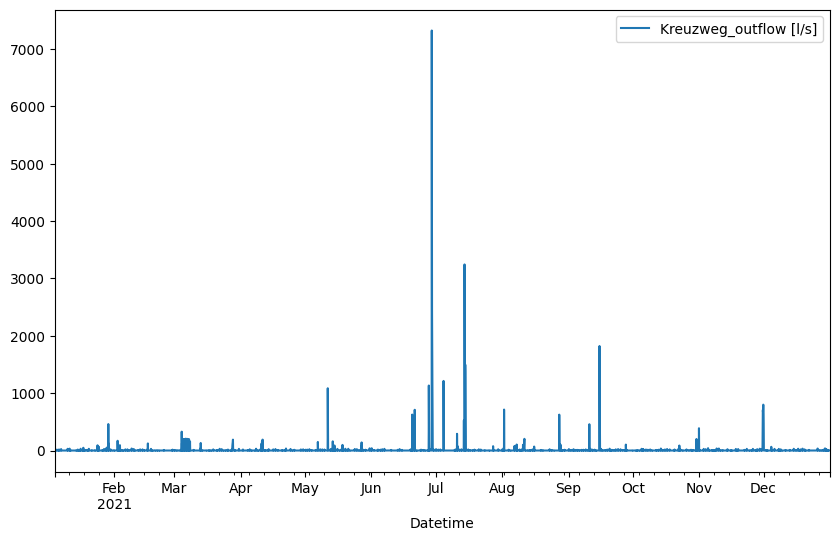

In [40]:
dp = VierlindenDataProcessor()
df = dp.load_processed_data()
df = dp.prepare_for_target(df, 'Kreuzweg_outflow [l/s]')
dp.plot_target_col('Kreuzweg_outflow [l/s]')

In [41]:
dp = VierlindenDataProcessor()
df = dp.load_processed_data()
df = dp.prepare_for_target(df, 'Kreuzweg_outflow [l/s]')

training_df, test_df = VierlindenDataProcessor.split_data(df, train_frac=0.9)
test_df.shape

INFO:vierlinden.data.loader:Data loaded successfully from /storage/projects/RIWWER/data/Vierlinden


INFO:vierlinden.data.loader:Sensor and target data merged successfully.
INFO:vierlinden.data.loader:NaN values processed successfully.
INFO:vierlinden.data.loader:Data loaded and processed successfully.


(868, 24)

In [42]:
nhits_wrapper, test_df = main('Kreuzweg_outflow [l/s]')
nhits_wrapper.save_trained_model(model_output_path + "/"  + 'NHiTS_Kreuzweg_model.pt')

model = nhits_wrapper.best_model

INFO:vierlinden.data.loader:Data loaded successfully from /storage/projects/RIWWER/data/Vierlinden


INFO:vierlinden.data.loader:Sensor and target data merged successfully.
INFO:vierlinden.data.loader:NaN values processed successfully.
INFO:vierlinden.data.loader:Data loaded and processed successfully.
INFO:vierlinden.model.model:Training and validation data and data loaders created successfully.
Global seed set to 42
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 59.41it/s]
INFO:vierlinden.model.model:Start setting up trainer and network.
Global seed set to 42
INFO:vierlinden.model.model:Setup succesful. Starting training procedure.

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | MAE            | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 919 K 
---------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.679     Total estimated 

Optimal learning rate for Kreuzweg_outflow [l/s]: 0.00012589254117941672
Epoch 0: 100%|██████████| 193/193 [01:11<00:00,  2.69it/s, v_num=0, train_loss_step=10.80, val_loss=3.570, train_loss_epoch=24.20]

Metric val_loss improved. New best score: 3.566


Epoch 1: 100%|██████████| 193/193 [00:36<00:00,  5.23it/s, v_num=0, train_loss_step=19.20, val_loss=3.350, train_loss_epoch=23.00]

Metric val_loss improved by 0.212 >= min_delta = 0.0001. New best score: 3.354


Epoch 2: 100%|██████████| 193/193 [00:35<00:00,  5.39it/s, v_num=0, train_loss_step=44.70, val_loss=3.270, train_loss_epoch=22.10]

Metric val_loss improved by 0.086 >= min_delta = 0.0001. New best score: 3.267


Epoch 3: 100%|██████████| 193/193 [00:34<00:00,  5.55it/s, v_num=0, train_loss_step=5.110, val_loss=3.210, train_loss_epoch=21.20]

Metric val_loss improved by 0.061 >= min_delta = 0.0001. New best score: 3.206


Epoch 4:   0%|          | 0/193 [00:00<?, ?it/s, v_num=0, train_loss_step=5.110, val_loss=3.210, train_loss_epoch=21.20]          

Swapping scheduler `ReduceLROnPlateau` for `SWALR`


Epoch 4: 100%|██████████| 193/193 [00:35<00:00,  5.47it/s, v_num=0, train_loss_step=9.860, val_loss=3.160, train_loss_epoch=20.20]

Metric val_loss improved by 0.050 >= min_delta = 0.0001. New best score: 3.156


Epoch 5: 100%|██████████| 193/193 [00:36<00:00,  5.23it/s, v_num=0, train_loss_step=5.100, val_loss=3.120, train_loss_epoch=19.60]

Metric val_loss improved by 0.033 >= min_delta = 0.0001. New best score: 3.123


Epoch 6: 100%|██████████| 193/193 [00:33<00:00,  5.84it/s, v_num=0, train_loss_step=27.90, val_loss=3.120, train_loss_epoch=19.10]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 3.120


Epoch 7: 100%|██████████| 193/193 [00:39<00:00,  4.92it/s, v_num=0, train_loss_step=39.80, val_loss=3.050, train_loss_epoch=18.60]

Metric val_loss improved by 0.071 >= min_delta = 0.0001. New best score: 3.050


Epoch 8: 100%|██████████| 193/193 [00:36<00:00,  5.24it/s, v_num=0, train_loss_step=8.130, val_loss=3.040, train_loss_epoch=18.40]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 3.042


Epoch 10: 100%|██████████| 193/193 [00:34<00:00,  5.65it/s, v_num=0, train_loss_step=5.920, val_loss=2.950, train_loss_epoch=17.80]

Metric val_loss improved by 0.089 >= min_delta = 0.0001. New best score: 2.953


Epoch 11: 100%|██████████| 193/193 [00:37<00:00,  5.13it/s, v_num=0, train_loss_step=22.30, val_loss=2.950, train_loss_epoch=17.70]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.949


Epoch 12: 100%|██████████| 193/193 [00:33<00:00,  5.79it/s, v_num=0, train_loss_step=8.880, val_loss=2.900, train_loss_epoch=17.50]

Metric val_loss improved by 0.047 >= min_delta = 0.0001. New best score: 2.902


Epoch 13: 100%|██████████| 193/193 [00:33<00:00,  5.75it/s, v_num=0, train_loss_step=4.910, val_loss=2.840, train_loss_epoch=17.40]

Metric val_loss improved by 0.061 >= min_delta = 0.0001. New best score: 2.842


Epoch 14: 100%|██████████| 193/193 [00:37<00:00,  5.17it/s, v_num=0, train_loss_step=5.830, val_loss=2.820, train_loss_epoch=17.00]

Metric val_loss improved by 0.022 >= min_delta = 0.0001. New best score: 2.820


Epoch 15: 100%|██████████| 193/193 [00:37<00:00,  5.20it/s, v_num=0, train_loss_step=30.50, val_loss=2.810, train_loss_epoch=16.80]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.813


Epoch 16: 100%|██████████| 193/193 [00:36<00:00,  5.22it/s, v_num=0, train_loss_step=1.910, val_loss=2.770, train_loss_epoch=16.80]

Metric val_loss improved by 0.045 >= min_delta = 0.0001. New best score: 2.768


Epoch 17: 100%|██████████| 193/193 [00:34<00:00,  5.67it/s, v_num=0, train_loss_step=8.160, val_loss=2.710, train_loss_epoch=16.90]

Metric val_loss improved by 0.055 >= min_delta = 0.0001. New best score: 2.713


Epoch 19: 100%|██████████| 193/193 [00:34<00:00,  5.53it/s, v_num=0, train_loss_step=10.10, val_loss=2.610, train_loss_epoch=16.40]

Metric val_loss improved by 0.106 >= min_delta = 0.0001. New best score: 2.607


Epoch 20: 100%|██████████| 193/193 [00:34<00:00,  5.64it/s, v_num=0, train_loss_step=14.20, val_loss=2.590, train_loss_epoch=16.30]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 2.593


Epoch 21: 100%|██████████| 193/193 [00:34<00:00,  5.55it/s, v_num=0, train_loss_step=5.870, val_loss=2.560, train_loss_epoch=16.20]

Metric val_loss improved by 0.030 >= min_delta = 0.0001. New best score: 2.562


Epoch 22: 100%|██████████| 193/193 [00:36<00:00,  5.22it/s, v_num=0, train_loss_step=28.50, val_loss=2.500, train_loss_epoch=16.10]

Metric val_loss improved by 0.058 >= min_delta = 0.0001. New best score: 2.505


Epoch 23: 100%|██████████| 193/193 [00:40<00:00,  4.79it/s, v_num=0, train_loss_step=13.80, val_loss=2.470, train_loss_epoch=15.80]

Metric val_loss improved by 0.033 >= min_delta = 0.0001. New best score: 2.472


Epoch 24: 100%|██████████| 193/193 [00:37<00:00,  5.20it/s, v_num=0, train_loss_step=8.190, val_loss=2.440, train_loss_epoch=15.80]

Metric val_loss improved by 0.032 >= min_delta = 0.0001. New best score: 2.440


Epoch 25: 100%|██████████| 193/193 [00:33<00:00,  5.81it/s, v_num=0, train_loss_step=15.00, val_loss=2.400, train_loss_epoch=15.70]

Metric val_loss improved by 0.040 >= min_delta = 0.0001. New best score: 2.400


Epoch 26: 100%|██████████| 193/193 [00:38<00:00,  4.99it/s, v_num=0, train_loss_step=4.950, val_loss=2.370, train_loss_epoch=15.50]

Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 2.374


Epoch 27: 100%|██████████| 193/193 [00:36<00:00,  5.22it/s, v_num=0, train_loss_step=8.390, val_loss=2.340, train_loss_epoch=15.20]

Metric val_loss improved by 0.035 >= min_delta = 0.0001. New best score: 2.339


Epoch 28: 100%|██████████| 193/193 [00:44<00:00,  4.30it/s, v_num=0, train_loss_step=4.630, val_loss=2.320, train_loss_epoch=15.40]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 2.319


Epoch 29: 100%|██████████| 193/193 [00:34<00:00,  5.63it/s, v_num=0, train_loss_step=48.60, val_loss=2.300, train_loss_epoch=15.50]

Metric val_loss improved by 0.018 >= min_delta = 0.0001. New best score: 2.301


Epoch 30: 100%|██████████| 193/193 [00:37<00:00,  5.20it/s, v_num=0, train_loss_step=4.950, val_loss=2.230, train_loss_epoch=15.10]

Metric val_loss improved by 0.075 >= min_delta = 0.0001. New best score: 2.226


Epoch 31: 100%|██████████| 193/193 [00:36<00:00,  5.22it/s, v_num=0, train_loss_step=6.690, val_loss=2.180, train_loss_epoch=15.10]

Metric val_loss improved by 0.050 >= min_delta = 0.0001. New best score: 2.176


Epoch 32: 100%|██████████| 193/193 [00:35<00:00,  5.46it/s, v_num=0, train_loss_step=4.460, val_loss=2.150, train_loss_epoch=15.00]

Metric val_loss improved by 0.030 >= min_delta = 0.0001. New best score: 2.146


Epoch 34: 100%|██████████| 193/193 [00:34<00:00,  5.63it/s, v_num=0, train_loss_step=12.70, val_loss=2.090, train_loss_epoch=14.80]

Metric val_loss improved by 0.059 >= min_delta = 0.0001. New best score: 2.087


Epoch 36: 100%|██████████| 193/193 [00:35<00:00,  5.39it/s, v_num=0, train_loss_step=7.330, val_loss=2.040, train_loss_epoch=14.40]

Metric val_loss improved by 0.049 >= min_delta = 0.0001. New best score: 2.038


Epoch 37: 100%|██████████| 193/193 [00:35<00:00,  5.49it/s, v_num=0, train_loss_step=4.230, val_loss=2.030, train_loss_epoch=14.60]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.035


Epoch 38: 100%|██████████| 193/193 [00:37<00:00,  5.15it/s, v_num=0, train_loss_step=11.60, val_loss=2.000, train_loss_epoch=14.60]

Metric val_loss improved by 0.031 >= min_delta = 0.0001. New best score: 2.004


Epoch 39: 100%|██████████| 193/193 [00:34<00:00,  5.57it/s, v_num=0, train_loss_step=4.280, val_loss=1.970, train_loss_epoch=14.60]

Metric val_loss improved by 0.036 >= min_delta = 0.0001. New best score: 1.968


Epoch 41: 100%|██████████| 193/193 [00:34<00:00,  5.54it/s, v_num=0, train_loss_step=4.190, val_loss=1.950, train_loss_epoch=14.50]

Metric val_loss improved by 0.020 >= min_delta = 0.0001. New best score: 1.948


Epoch 43: 100%|██████████| 193/193 [00:35<00:00,  5.49it/s, v_num=0, train_loss_step=2.490, val_loss=1.940, train_loss_epoch=14.30]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 1.943


Epoch 44: 100%|██████████| 193/193 [00:47<00:00,  4.05it/s, v_num=0, train_loss_step=9.410, val_loss=1.920, train_loss_epoch=14.40]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 1.922


Epoch 47: 100%|██████████| 193/193 [00:37<00:00,  5.13it/s, v_num=0, train_loss_step=10.60, val_loss=1.910, train_loss_epoch=14.40]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 1.906


Epoch 48: 100%|██████████| 193/193 [00:36<00:00,  5.34it/s, v_num=0, train_loss_step=2.690, val_loss=1.900, train_loss_epoch=14.20]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 1.895


Epoch 49: 100%|██████████| 193/193 [00:35<00:00,  5.38it/s, v_num=0, train_loss_step=7.320, val_loss=1.890, train_loss_epoch=14.30]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 1.887


Epoch 52: 100%|██████████| 193/193 [00:40<00:00,  4.81it/s, v_num=0, train_loss_step=86.50, val_loss=1.880, train_loss_epoch=14.10]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 1.883


Epoch 53: 100%|██████████| 193/193 [00:34<00:00,  5.62it/s, v_num=0, train_loss_step=5.100, val_loss=1.860, train_loss_epoch=14.20]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 1.862


Epoch 54: 100%|██████████| 193/193 [00:39<00:00,  4.89it/s, v_num=0, train_loss_step=3.610, val_loss=1.860, train_loss_epoch=14.10]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 1.861


Epoch 59: 100%|██████████| 193/193 [00:37<00:00,  5.08it/s, v_num=0, train_loss_step=4.020, val_loss=1.840, train_loss_epoch=14.10]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 1.845


Epoch 61: 100%|██████████| 193/193 [00:37<00:00,  5.19it/s, v_num=0, train_loss_step=2.930, val_loss=1.840, train_loss_epoch=13.90]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 1.840


Epoch 67: 100%|██████████| 193/193 [00:39<00:00,  4.92it/s, v_num=0, train_loss_step=6.000, val_loss=1.830, train_loss_epoch=13.90]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 1.830


Epoch 71: 100%|██████████| 193/193 [00:41<00:00,  4.70it/s, v_num=0, train_loss_step=10.00, val_loss=1.820, train_loss_epoch=13.90]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 1.819


Epoch 76: 100%|██████████| 193/193 [00:37<00:00,  5.15it/s, v_num=0, train_loss_step=7.820, val_loss=1.810, train_loss_epoch=13.50]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 1.810


Epoch 85: 100%|██████████| 193/193 [00:43<00:00,  4.39it/s, v_num=0, train_loss_step=2.120, val_loss=1.810, train_loss_epoch=13.60]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 1.808


Epoch 86: 100%|██████████| 193/193 [00:38<00:00,  5.01it/s, v_num=0, train_loss_step=4.460, val_loss=1.800, train_loss_epoch=13.60]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 1.796


Epoch 87: 100%|██████████| 193/193 [00:39<00:00,  4.86it/s, v_num=0, train_loss_step=24.80, val_loss=1.790, train_loss_epoch=13.40]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 1.789


Epoch 88: 100%|██████████| 193/193 [00:40<00:00,  4.74it/s, v_num=0, train_loss_step=2.300, val_loss=1.790, train_loss_epoch=13.70]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 1.786


Epoch 97: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s, v_num=0, train_loss_step=16.70, val_loss=1.780, train_loss_epoch=13.50]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 1.781


Epoch 99: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s, v_num=0, train_loss_step=3.160, val_loss=1.790, train_loss_epoch=13.40]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 193/193 [00:39<00:00,  4.84it/s, v_num=0, train_loss_step=3.160, val_loss=1.790, train_loss_epoch=13.40]


INFO:vierlinden.model.model:Training procedure completed.
INFO:vierlinden.model.model:Cleaning up logging files.
INFO:vierlinden.model.model:Logging files cleaned up.


[24.20244026184082, 23.043241500854492, 22.111543655395508, 21.156574249267578, 20.24938201904297, 19.58340835571289, 19.133193969726562, 18.623258590698242, 18.354463577270508, 18.218605041503906, 17.801973342895508, 17.749134063720703, 17.513717651367188, 17.3950252532959, 17.036529541015625, 16.815961837768555, 16.75874900817871, 16.89653968811035, 16.47618293762207, 16.366111755371094, 16.317317962646484, 16.242443084716797, 16.058515548706055, 15.756258964538574, 15.79803466796875, 15.714713096618652, 15.544419288635254, 15.23621940612793, 15.380220413208008, 15.480043411254883, 15.118422508239746, 15.103930473327637, 14.96529769897461, 15.059423446655273, 14.783975601196289, 14.849761009216309, 14.415291786193848, 14.637709617614746, 14.581522941589355, 14.580175399780273, 14.626948356628418, 14.507091522216797, 14.22571849822998, 14.276739120483398, 14.354999542236328, 14.337696075439453, 14.251818656921387, 14.429985046386719, 14.208369255065918, 14.33565902709961, 14.238594055

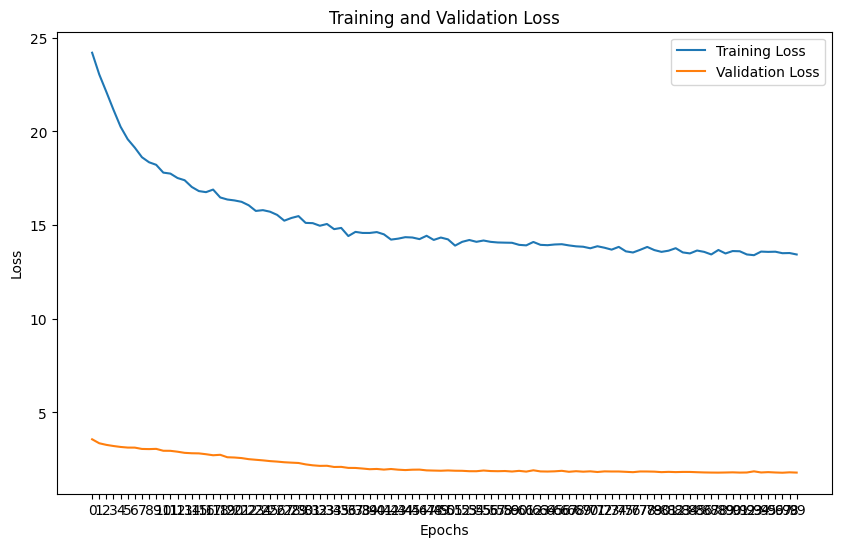

In [43]:
print(nhits_wrapper.metrics_callback.metrics["train_loss"])
print(nhits_wrapper.metrics_callback.metrics["val_loss"])

nhits_wrapper.plot_training_result()

In [44]:
model = NHiTSTrainingWrapper.load_trained_model(model_output_path + "/"  + 'NHiTS_Kreuzweg_model_mase.pt')

In [45]:
prediction_wrapper = NHiTSPredictionWrapper(model, context_length=context_length, prediction_length=prediction_length, target_col='Kreuzweg_outflow [l/s]')
prediction_df = prediction_wrapper.predict(test_df)

/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [46]:
prediction_df.iloc[110:120]

,Datetime,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflumenge_pval,Berechnete Durchflussmenge_pval,Fllstand SWS_pval,Fllstand RWS_pval,Strom P1_pval,Strom P2_pval,...,Strom Pumpe 1_pval,Strom Pumpe 2_pval,Fllstand Pumpensumpf_pval1,Strom Pumpe 1_pval1,Strom Pumpe 2_pval1,Strom Pumpe 3_pval,Niederschlag,Füllstand_RRB,Kreuzweg_outflow [l/s],Predicted Forecast
110,2021-11-30 10:00:00,100.0,18.578947,12.140625,41.424528,39.932039,102.900000,35.000000,7.000000,0.000000,...,1.064516,0.677419,91.021739,3.548387,0.0,1.0,0.900000,0.67,0.000000,"[-0.0166168212890625, 0.0001392364501953125, -..."
111,2021-11-30 11:00:00,100.0,18.518072,12.318841,41.348624,38.694444,75.859649,35.000000,5.842105,0.000000,...,0.580645,0.000000,91.051948,0.000000,0.0,1.0,0.885366,0.67,0.000000,"[-0.0029697418212890625, 0.019370079040527344,..."
112,2021-11-30 12:00:00,100.0,20.239437,13.214286,46.018868,46.231481,75.633333,35.000000,5.066667,0.000000,...,0.580645,1.000000,89.252632,3.709677,0.0,1.0,1.237500,0.67,0.000000,"[-1.5974044799804688e-05, 0.008974313735961914..."
113,2021-11-30 13:00:00,100.0,34.907216,22.023256,130.716667,109.172414,106.850000,35.000000,4.616667,16.666667,...,3.540984,5.078125,109.024096,9.016393,0.0,1.0,2.779592,0.67,80.327074,"[-0.03258633613586426, 0.0021522045135498047, ..."
114,2021-11-30 14:00:00,100.0,39.345679,24.333333,157.921053,129.577982,112.516667,35.416667,3.716667,25.150000,...,5.492308,5.000000,126.337079,10.000000,0.0,1.0,2.937391,0.69,337.788898,"[6.872893333435059, 4.611355304718018, 3.94871..."
115,2021-11-30 15:00:00,100.0,36.766234,22.929577,142.059829,115.964286,118.483333,36.000000,4.000000,16.633333,...,5.343284,5.000000,143.558824,10.000000,0.0,1.0,2.153571,0.70,519.748537,"[31.599939346313477, 20.17141342163086, 16.370..."
116,2021-11-30 16:00:00,100.0,39.385542,24.225000,158.060870,131.165138,117.816667,36.500000,3.933333,22.133333,...,5.380282,5.000000,153.394737,10.000000,0.0,1.0,2.651282,1.05,654.730181,"[65.69389343261719, 33.706398010253906, 26.271..."
117,2021-11-30 17:00:00,100.0,27.098765,17.081081,84.297297,73.449541,134.150000,37.000000,5.750000,1.833333,...,5.109375,5.000000,150.426966,10.000000,0.0,1.0,0.975000,2.40,709.151111,"[101.20944213867188, 44.986488342285156, 33.03..."
118,2021-11-30 18:00:00,100.0,22.397436,14.292683,57.223214,54.355140,134.183333,37.000000,5.800000,3.783333,...,5.132353,5.000000,111.203883,10.000000,0.0,1.0,1.688000,2.45,669.507342,"[142.61245727539062, 61.41664123535156, 46.929..."
119,2021-11-30 19:00:00,100.0,28.647887,17.860759,91.504505,81.609091,129.883333,37.000000,5.200000,5.466667,...,5.032258,5.000000,89.215909,5.645161,0.0,1.0,1.187755,2.46,725.439406,"[158.35769653320312, 65.24545288085938, 49.053..."


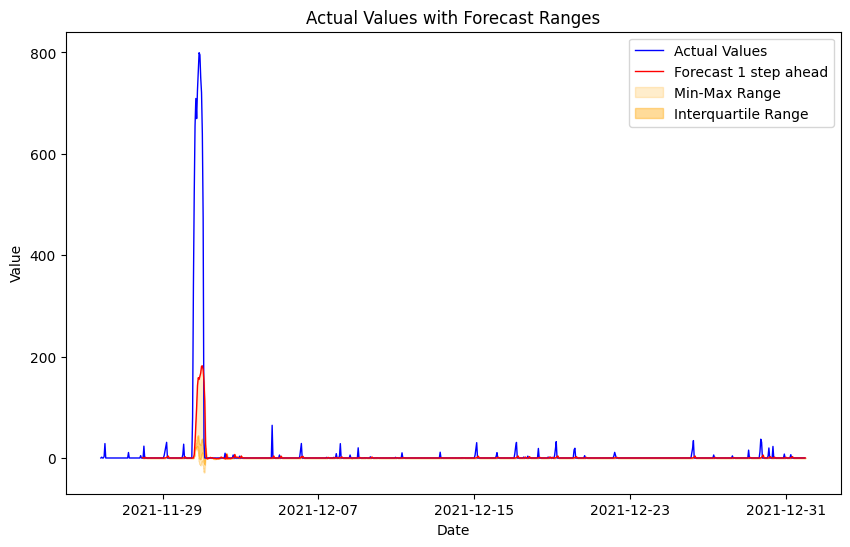

In [49]:
prediction_wrapper.plot_forecast_for_all(forecast_step_ahead=1, plot_forecast_distribution=True)

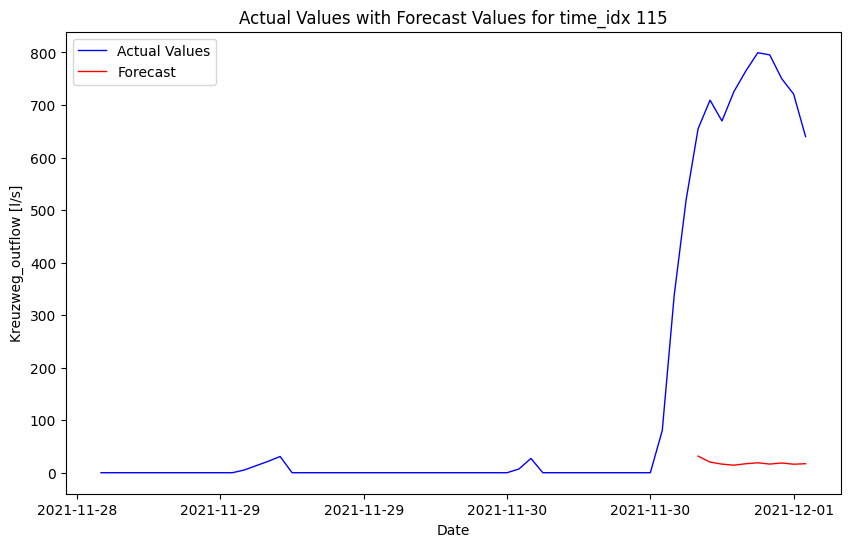

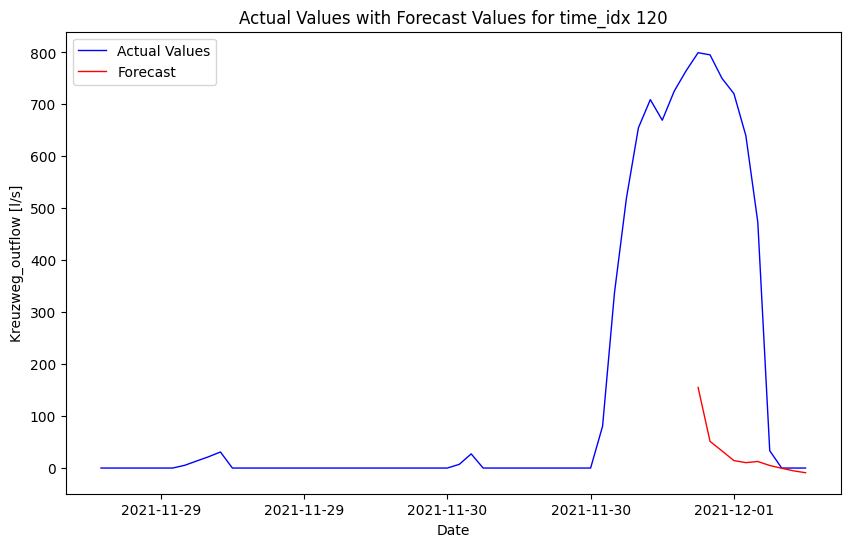

In [50]:
prediction_wrapper.plot_forecast_per_time_idx(115)
prediction_wrapper.plot_forecast_per_time_idx(120)

In [51]:
print(model)

NHiTS(
  	"activation":                        ReLU
  	"backcast_loss_ratio":               1.0
  	"batch_normalization":               False
  	"categorical_groups":                {}
  	"context_length":                    50
  	"downsample_frequencies":            [8, 2, 1]
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       512
  	"initialization":                    lecun_normal
  	"interpolation_mode":                linear
  	"learning_rate":                     0.00012589254117941672
  	"log_gradient_flow":                 False
  	"log_interval":                      5
  	"log_val_interval":                  1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              MASE()
  	"monotone_constaints